# Tufts BAT Team 2 - Reds Hackathon Notebook
### Authored by Richard Diamond, Jackson Ehrlich, Ben Goldberg, Ronan Hwang and Wesley Rivers

# Introduction
The performance of every player is broken down into dozens of different statistics, collected during every pitch, at bat, and fielding opportunity. With this data, front offices attempt to “rate” a player’s abilities. But these attributes are driven by the bodily capital that a player offers. If a player’s body is unable to perform at their maximum capacity, it is unlikely that they will provide value to a major league club. In simple terms, if a player cannot play, they are no help to their team.

Using the data provided, we started our process by brainstorming the attributes that would most likely impact a player’s availability. After organizing our data, we constructed two RandomForest models, one for batters and one for pitchers. These RandomForest models would not only help us make predictions, but highlight what factors lead to higher number of plate appearances and batters faced.


#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data Preprocessing

### People Database

One of the first datasets we worked on was the Lahman people database. This database provided information on players' age, height, weight and handedness.  
Our main challenge here was finding players' ages by year. Since our inputs to our model would be a player's season-long data, we needed to ensure that the age variable matched exactly how old they were at the start of the season. Our code for this is linked in this [age.ipynb](https://colab.research.google.com/drive/1PyLGEKjBTSPwJvf7hO3jDC37BITl8hj-?authuser=2#scrollTo=LbJ4oeck6_6T) notebook.  
From this dataset, we exported age, weight, height, batting handedness and pitching handedness.

### Batting Data
Since our plan was to have two distinct models for batting and for pitching, we started by gathering relevant batter data. the first thing we sought to gather was any given player's pitches played in the field in their previous year. This was a simple calculation based on the baseball savant pitches database, as all we had to do was see how many times a player was listed as one of the nine fielders in savant's data in any given year.  


From there, we then gathered information on what a player's primary position was in a given year. Primary position was gathered by finding the position at which a player appeared the most times in that given season.
We then gathered the amount of plate appearances a player had in any given year. We did this by creating a unique plate appearance id as follows:



```
def get_unique_pa_id(row):
    game_pk = str(row['game_pk'])  # Game ID
    inning = str(row['inning'])  # Inning number
    outs_when_up = str(row['outs_when_up'])  # Outs when batter comes up
    bat_score = str(row['bat_score'])  # Batting score
    topbot = str(row['inning_topbot'])  # Top or Bottom of inning
    batter = str(row['batter'])  # Batter
    pitcher = str(row['pitcher'])  # Pitcher

    # Include both batter and pitcher to ensure unique ID per role
    return f"{game_pk}_{inning}_{outs_when_up}_{bat_score}_{topbot}_{batter}_{pitcher}"

```

We then counted the amount of times each player was batting with a unique id and used that as our ground-truth amount of plate appearances.  

Lastly, we found batters' three true outcome percentage. We defined this as the percentage of a batter's plate appearances where they struck out, walked, were hit by a pitch or hit a home run. We then merged this data together to get a complete picture of all batter data.




### Pitching Data
Our pitching data preprocessing was similar to our batting data preprocessing. We gathered batters faced and pitches as variables similarly, and then continued to gather fastball velocity average, as well as relief percentage. We defined relief percentage as the number of pitches thrown as a reliever divided by the total number of pitches thrown. For instance, if a player only ever appears as a reliever, their relief percentage would be 1.0.
### Gathering Previous Year Data
We did not want to use any data from year x to predict the number of plate appearances or batters faced in year x. Based on this, we needed to offset each data point by one year. For instance, when trying to predict Francisco Lindor's 2023 plate appearances, we fed the model his values from 2022.
### Preprocessing notebook

The notebook that we used for most of our preprocessing work is called [prepare_data.ipynb](https://colab.research.google.com/drive/1cLhoqBh9uqqnbVBf0W1fMKXX0GH1c0f8?authuser=2#scrollTo=32kmHEh_4G8S).

# RandomForest Model
We tried many different models for this task, but decided on a RandomForest model. RandomForest models offer good explainability as well as predictive power. More documentation on RandomForest can be found [here](https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/).

### Setup
We first had to mount our drive, and load in our dataset.

In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load in data
data = pd.read_csv('/content/drive/MyDrive/RedsComp25/redscomp_data.csv')

#filter out 2021, as we have no previous year data here (more discussion to follow)
data = data[data['year'] > 2021]

We then build a one-hot encoding for our primary position variable, in order to make it compatible with any model we would build.

In [4]:
#use one hot encoding to encode position (categorical variable)
data = pd.get_dummies(data, columns=['prev_year_primary_position'], prefix='position')

#use one hot encoding to encode bats column
data = pd.get_dummies(data, columns=['bats'], prefix='bats')

We then also had to make our righty-lefty variables numeric.

In [5]:
#convert throws to 0-1 (0 = lefty, 1 = righty)
data['throws'] = data['throws'].map({'L': 0, 'R': 1})

### Feature selection
We then moved onto selecting features for our models, as shown below:

In [6]:
#features for our batting model
features_batting = ['weight', 'height', 'age', 'throws',
            'prev_year_pitches_played_in_field', 'prev_year_pa', 'prev_year_tto', 'bats_L', 'bats_R', 'bats_B',
            'position_0.0','position_2.0', 'position_3.0', 'position_4.0', 'position_5.0',
              'position_6.0', 'position_7.0', 'position_8.0', 'position_9.0']
target = ['pa']

In [7]:
#features for pitching model
features_pitching = ['weight', 'height', 'age', 'throws', 'prev_year_pitches_thrown',
             'prev_year_bf', 'prev_year_pct_relief']
target_pitching = ['bf']

### Splitting data into train and test
To build our model, we needed to define a train and test set individually for both batters and pitchers:

In [8]:
data_batting_short = data[['player', 'weight', 'height', 'age', 'bats_L', 'bats_R', 'bats_B','throws', 'position_0.0', 'position_1.0',
       'position_2.0', 'position_3.0', 'position_4.0', 'position_5.0',
       'position_6.0', 'position_7.0', 'position_8.0', 'position_9.0',
            'prev_year_pitches_played_in_field', 'prev_year_tto', 'prev_year_pa', 'pa']].dropna()

#filter pitchers out of our batting df
data_batting_short = data_batting_short[data_batting_short['position_1.0'] != True]


data_pitching_short = data[['player','weight', 'height', 'age', 'throws', 'prev_year_pitches_thrown',
            'prev_year_fastball_avg_velo', 'prev_year_bf',
                            'prev_year_pct_relief', 'bf', 'position_1.0']].dropna()

In [9]:
#split dataset into features and target
X_batting = data_batting_short[features_batting].dropna()
y_batting = data_batting_short[target].dropna()


X_pitching = data_pitching_short[features_pitching].dropna()
y_pitching = data_pitching_short[target_pitching]

In [10]:
# Train-test split with 25% test size
X_train_batting, X_test_batting, y_train_batting, y_test_batting = train_test_split(X_batting, y_batting, test_size=0.25, random_state=33)
X_train_pitching, X_test_pitching, y_train_pitching, y_test_pitching = train_test_split(X_pitching, y_pitching, test_size=0.25, random_state=42)

# Check the shapes to confirm the split
print('BATTING')
print(f"X_train shape: {X_train_batting.shape}")
print(f"X_test shape: {X_test_batting.shape}")
print(f"y_train shape: {y_train_batting.shape}")
print(f"y_test shape: {y_test_batting.shape}")

print('PITCHING')
print(f"X_train shape: {X_train_pitching.shape}")
print(f"X_test shape: {X_test_pitching.shape}")
print(f"y_train shape: {y_train_pitching.shape}")
print(f"y_test shape: {y_test_pitching.shape}")

BATTING
X_train shape: (744, 19)
X_test shape: (249, 19)
y_train shape: (744, 1)
y_test shape: (249, 1)
PITCHING
X_train shape: (884, 7)
X_test shape: (295, 7)
y_train shape: (884, 1)
y_test shape: (295, 1)


### Hyperparameter grid search
We then build a hyperparameter grid search for both batters and pitchers. We refined our hyperparameter grids many times over, continuously improving it until we ended up with reasonable values.

In [11]:
# Define the hyperparameter grid for our batting model
param_grid_batting = {
    'n_estimators': [35, 50],
    'max_depth': [3, 5, 7 , 9],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3],
}

rf_model_batting = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model_batting, param_grid=param_grid_batting,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_batting, y_train_batting.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [35, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [12]:
# Best hyperparameters
print(f"Best Parameters for batting grid search: {grid_search.best_params_}")

# Best MSE score
best_mse = -grid_search.best_score_  # Convert back from negative MSE
print(f"Best Cross-Validated MSE: {best_mse}")

Best Parameters for batting grid search: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 35}
Best Cross-Validated MSE: 25330.703724758383


In [13]:
# Define the hyperparameter grid for pitching
param_grid_pitching = {
    'n_estimators': [15, 20],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2,3],
}
rf_model_pitching = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_pitching = GridSearchCV(estimator=rf_model_pitching, param_grid=param_grid_pitching,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit GridSearchCV
grid_search_pitching.fit(X_train_pitching, y_train_pitching.values.ravel())


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [15, 20]},
             scoring='neg_mean_squared_error', verbose=2)

In [14]:
# Best hyperparameters
print(f"Best Parameters for pitching model: {grid_search_pitching.best_params_}")

# Best MSE score
best_mse_pitching = -grid_search_pitching.best_score_  # Convert back from negative MSE
print(f"Best Cross-Validated MSE: {best_mse_pitching}")

Best Parameters for pitching model: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Best Cross-Validated MSE: 26736.145425366518


#Results
### Batting Model
As seen below, our batting model has an RMSE of ~148.

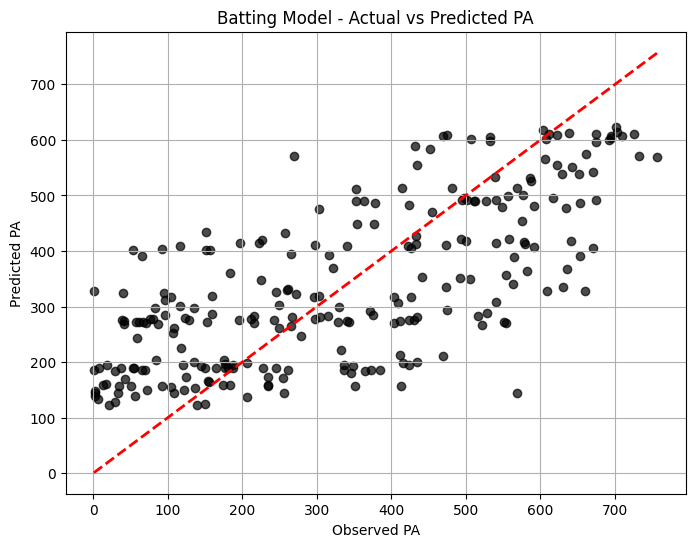

In [15]:
# Make predictions using the best estimator
best_rf_model_batting = grid_search.best_estimator_
y_pred_batting = best_rf_model_batting.predict(X_test_batting)

# Plotting the predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_batting, y_pred_batting, alpha=0.7, color='black')
plt.plot([y_test_batting.min(), y_test_batting.max()], [y_test_batting.min(), y_test_batting.max()], 'r--', lw=2)
plt.xlabel('Observed PA')
plt.ylabel('Predicted PA')
plt.title('Batting Model - Actual vs Predicted PA')
plt.grid(True)
plt.show()

In [16]:
# Calculate RMSE
mse = mean_squared_error(y_test_batting, y_pred_batting)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 148.0212


### Pitching Model
Our pitching model's RMSE is roughly ~146, slightly better than our batting model.

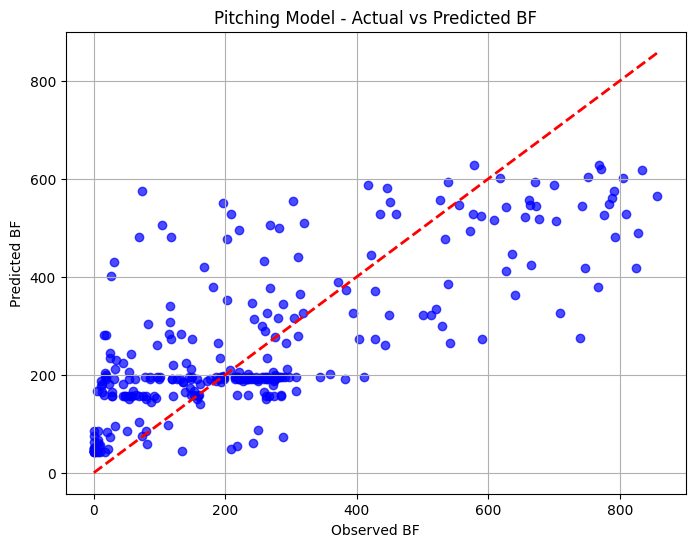

In [17]:
# Make predictions using the best estimator
best_rf_model_pitching = grid_search_pitching.best_estimator_
y_pred_pitching = best_rf_model_pitching.predict(X_test_pitching)

# Plotting the predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pitching, y_pred_pitching, alpha=0.7, color='blue')
plt.plot([y_test_pitching.min(), y_test_pitching.max()], [y_test_pitching.min(), y_test_pitching.max()], 'r--', lw=2)
plt.xlabel('Observed BF')
plt.ylabel('Predicted BF')
plt.title('Pitching Model - Actual vs Predicted BF')
plt.grid(True)
plt.show()

In [18]:
# Calculate RMSE
mse = mean_squared_error(y_test_pitching, y_pred_pitching)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 146.7795


### Feature importances
Our next step was to further understand our model. To do this, we plotted feature importances for both our batting and out pitching models. Feature importance is essentially the amount of impurity a specific feature is able to clear in a RandomForest model. The idea here is that if a node splits data on a certain feature, and it decreases the impurity significantly, that feature will have high importance. More documentation on feature importances can be found [here](https://www.geeksforgeeks.org/feature-importance-with-random-forests/).

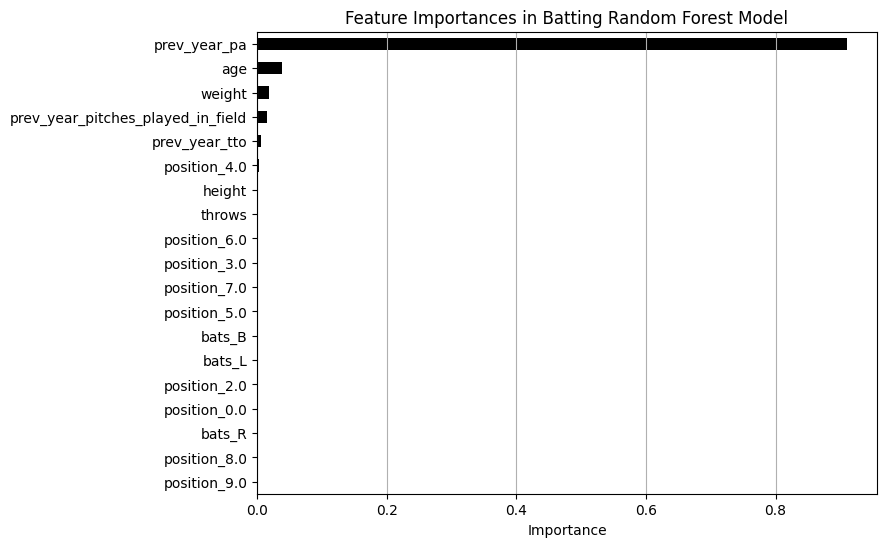

In [19]:
# Get feature importances from the best model
importances = best_rf_model_batting.feature_importances_

# Pair feature names with their importances
feature_importance = pd.Series(importances, index=features_batting).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh', color='black')
plt.xlabel('Importance')
plt.title('Feature Importances in Batting Random Forest Model')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()



As seen above, previous year plate appearances is by far the most predictive variable in terms of estimating plate appearances in the current year. While this makes sense, we were surprised to see that our other variables didn't end up having much predictive power.

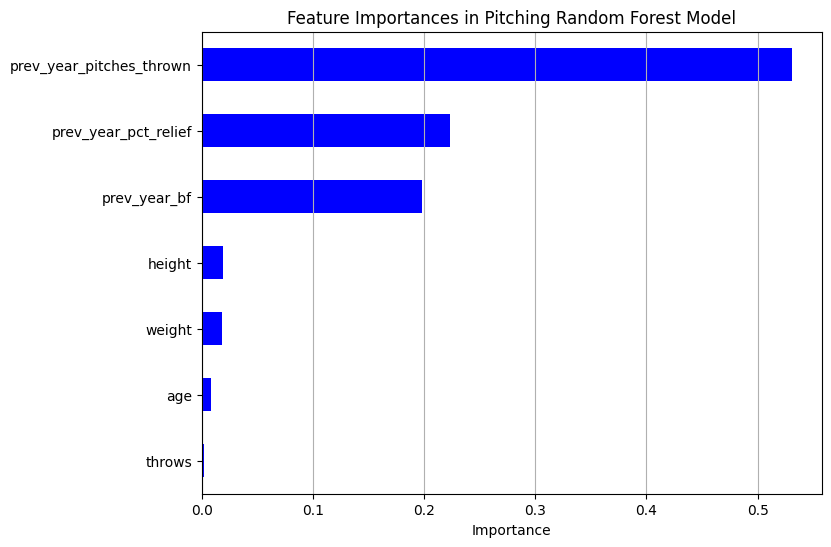

In [20]:
# Get feature importances from the best pitching model
importances_pitching = best_rf_model_pitching.feature_importances_

# Pair feature names with their importances
feature_importances_pitching = pd.Series(importances_pitching, index=features_pitching).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
feature_importances_pitching.plot(kind='barh', color='blue')
plt.xlabel('Importance')
plt.title('Feature Importances in Pitching Random Forest Model')
plt.gca().invert_yaxis()  # Invert to show the most important feature on top
plt.grid(axis='x')
plt.show()

As observed above, the most important feature here is the amount of pitches thrown in the previous year. This is interesting, because it has more predictive power than previous year batters faced. We believe this is because pitchers are most often pulled based on number of pitches as opposed to batters faced, and batters faced is a somewhat variable reflection of pitch count.
Also worth noting is that height, weight and age are not as predictive as we anticipated.

# Leaderboard Submission
We then needed to make predictions for every player in the dataset. To do this, we loaded in the sample submission to grab a list of players, and made predictions from there. Our final prediction for PA/BF is the sum of our PA predictions and our BF predictions for each player.

In [21]:
sample_submission = pd.read_csv('/content/drive/MyDrive/RedsComp25/sample_submission.csv')

In [22]:
#get 2023 data, as it is relevant to 2024 predictions
data_23 = data[data['year'] == 2023]
data_to_merge = data_23[['player', 'weight', 'height', 'age', 'bats_L', 'bats_R', 'bats_B', 'throws', 'primary_position', 'prev_year_tto',
            'pitches_played_in_field', 'pitches_thrown', 'ff_avg', 'position_0.0', 'position_1.0',
       'position_2.0', 'position_3.0', 'position_4.0', 'position_5.0',
       'position_6.0', 'position_7.0', 'position_8.0', 'position_9.0', 'pct_relief','bf', 'pa']]

#merge data with sample submission
sample_submission = pd.merge(sample_submission, data_to_merge,
                              left_on = 'PLAYER_ID', right_on='player', how='left')

#drop 'player' column as it is a duplicate
sample_submission = sample_submission.drop('player', axis=1)

#fill na values with zero
sample_submission = sample_submission.fillna(0)


In [23]:
#rename columns according to model architecture
sample_submission = sample_submission.rename(columns={'primary_position': 'prev_year_primary_position', 'pitches_played_in_field': 'prev_year_pitches_played_in_field',
                                  'pa': 'prev_year_pa', 'bf': 'prev_year_bf', 'pitches_thrown': 'prev_year_pitches_thrown',
                                  'ff_avg': 'prev_year_fastball_avg_velo', 'pct_relief': 'prev_year_pct_relief',
                                 'ff_avg': 'prev_year_fastball_avg_velo'
                                  })

In [24]:
#make plate appearance predictions
pred_plate_appearance = best_rf_model_batting.predict(sample_submission[features_batting])
sample_submission['predicted_pa'] = pred_plate_appearance

#make batters faced predictions
pred_batters_faced = best_rf_model_pitching.predict(sample_submission[features_pitching])
sample_submission['predicted_bf'] = pred_batters_faced

#make pa and bf zero respectively if prev year pa/bf is zero
sample_submission['predicted_pa'] = np.where(sample_submission['prev_year_pa'] == 0, 0, sample_submission['predicted_pa'])
sample_submission['predicted_bf'] = np.where(sample_submission['prev_year_bf'] == 0, 0, sample_submission['predicted_bf'])

#get final predicted playing time column through addition
sample_submission['PREDICTED_PLAYING_TIME'] = sample_submission['predicted_pa'] + sample_submission['predicted_bf']

#predict 100 for anybody who's prediction is zero (likely rookies)
sample_submission['PREDICTED_PLAYING_TIME'] = np.where(sample_submission['PREDICTED_PLAYING_TIME'] == 0, 100, sample_submission['PREDICTED_PLAYING_TIME'])


In [25]:
#shorten columns for final submission
final_submission = sample_submission[['PLAYER_ID', 'PREDICTED_PLAYING_TIME']]
final_submission = final_submission.rename(columns={'PREDICTED_PLAYING_TIME': 'PLAYING_TIME'})

In [26]:
#dump our final submission to csv
final_submission.to_csv('/content/drive/MyDrive/RedsComp25/tufts_submission.csv', index=False)

# Limitations

### Performance
Despite the efficacy of our model, there were some issues that we were unable to account for. One of these issues involved approaching the data from a 'roster-agnostic' perspective. Though we were trying to predict how many games a player is capable of playing in a vacuum, a player's number of plate appearances/batters faced in 2024 was very much affected by both their performance and the competition they faced from their teammates.

### Rookies
Another limitation we encountered was the challenge of making predictions for individuals with no prior data, such as rookies. Since our model relies exclusively on data from the previous year, it originally predicted zero appearances for players without historical records. To address this issue, we modified the model by assigning a baseline of 100 batters faced or plate appearances to those without prior data. While this approximation improved the model’s ability to estimate player availability compared to the initial approach, it remains a limitation.

### Team performance
Additionally, team performance can influence the number of games played by a player. In other words, if a team is winning games, they are more likely to start their best players as they try to win the division or grab a wild card spot. Conversely, a team that is unlikely to make the playoffs might give their better players time to rest and allow younger players or bench players to get more exposure.

### Specific culture-based decision making
Beyond team success and player performance, there are other reasons a team might choose to play or bench a player. Major League teams are full of internal politics that can push the time a player is on the field in either direction for a variety of reasons.

# Acknowledgements
We would like to thank the Cincinnati Reds for the data provided for this project.  
We relied on ChatGPT, StackOverflow and GeeksForGeeks for coding assistance throughout the project.